# Sensitivity analysis

(c) 2017 the authors. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT). 

In [2]:
# For operating system interaction
import os
import glob
import datetime
import sys
import re

# For loading .pkl files.
import pickle

# For scientific computing
import numpy as np
import pandas as pd
import scipy.special

# To compute symbolic expressions
import sympy
sympy.init_printing(use_unicode=True) # print outputs in LaTeX

# Import custom utilities
import mwc_induction_utils as mwc

# Useful plotting libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import corner
mwc.set_plotting_style()

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline (only use with static plots (non-Bokeh))
%config InlineBackend.figure_format = 'svg'

# Read the path to save output files
dropbox = open('../../doc/induction_paper/graphicspath.tex')
output = dropbox.read()
output = re.sub('\\graphicspath{{', '', output)
output = output[1::]
output = re.sub('}}\n', '', output)

/Users/razo/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:39: DeprecationWarning: bad escape \g


# Variability  in fold-change as parameter change.

An interesting observation during our analysis was the fact that as the repressor binding energy $\Delta\varepsilon_{RA}$ decreases (i.e. the repressor binds more strongly to the binding site) the width of the fold-change credible region gets wider.

In this notebook we will explore the origin of this observation by performing a *sensitivity analysis* where we analyze how much the fold-change changes as we vary the value of the dissociation constants for different binding energies.

## The model
Recall that the fold change equation is given by
$$
\text{fold-change} = \left( 1 + \frac{\left( 1 + \frac{c}{K_A} \right)^2}{\left( 1 + \frac{c}{K_A} \right)^2 + e^{-\beta \Delta\varepsilon_{AI}}\left( 1 + \frac{c}{K_I} \right)^2} \frac{R}{N_{NS}}e^{-\beta\Delta\varepsilon_{RA}} \right)^{-1},
\tag{1}
$$
where $\beta \equiv \frac{1}{k_BT}, $ $c$ is the inducer concentration, $K_A$ and $K_I$ are the dissociation constants of the inducer binding to the repressor in the active and inactive state, respectively, $\Delta\varepsilon_{AI}$ is the energy difference between the active and inactive state conformations, $R$ is the repressor copy number, $N_{NS}$ is the number of non-specific binding sites where the repressor can bind, and $\Delta\varepsilon_{RA}$ is the binding energy of the repressor to the DNA.

To study how the fold-change value changes as we vary the values of the dissociation constants we must compute $\frac{d\text{fold-change}}{dK_x}$. For this we will use Python's symbolic library `sympy`.

Let us first define the $p_{\text{act}}$, the probability of the repressor of being in the active state.

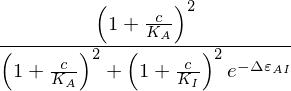

In [3]:
# Define the variables for the MWC p_active equatin
c, Ka, Ki, eai = sympy.symbols('c K_A K_I \\Delta\\varepsilon_{AI}')

p_act = (1 + c / Ka)**2 / ((1 + c / Ka)**2 + sympy.exp(- eai) * (1 + c / Ki)**2)
p_act

Now we define the full fold-change equation by including the missing variables

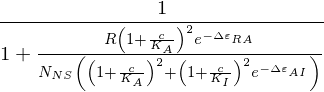

In [4]:
# Define the missing variables to compute the fold-change in gene expression
R, Nns, era = sympy.symbols('R N_NS \\Delta\\varepsilon_{RA}')

fold_change = (1 + p_act * (R / Nns) * sympy.exp(-era))**-1
fold_change

Having define the functions let us compute the derivative with respect to each of the dissociation constants.

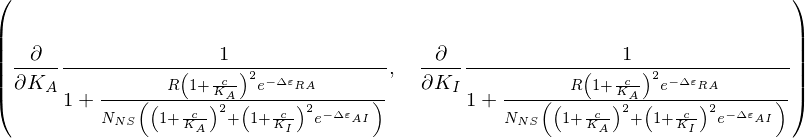

In [5]:
# Derivative with respect to dissociation constants
dfc_dKa = sympy.Derivative(fold_change, Ka)
dfc_dKi = sympy.Derivative(fold_change, Ki)

dfc_dKa, dfc_dKi

Let us now make `sympy` compute the explicit derivatives.

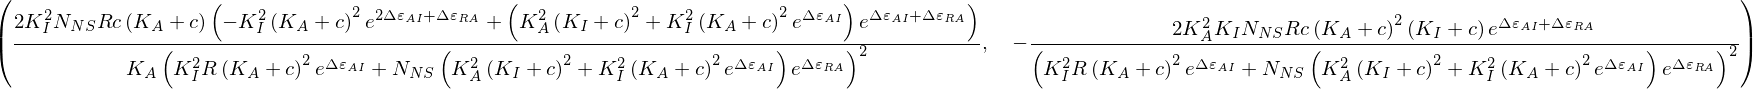

In [6]:
sympy.simplify(dfc_dKa.doit()), sympy.simplify(dfc_dKi.doit())

The expressions are definitely not easy to get our head around. Nevertheless we can still numerically compute the variation in fold-change as the dissociation constants are varied. For this we need to make these symbolic expressions functions that we can actually evaluate. This is simply done using the `lambdify` function from `sympy`.

In [7]:
# Generate lambdify functions that we can numerically evaluate
dfc_dKa_num = sympy.lambdify([c, Ka, Ki, eai, R, Nns, era],
                            dfc_dKa.doit(), 'numpy')
dfc_dKi_num = sympy.lambdify([c, Ka, Ki, eai, R, Nns, era],
                            dfc_dKi.doit(), 'numpy')

Let us now define the numerical values for all these variables.

In [8]:
Nns_num = 4.6E6 # bp
eai_num = 4.5 # kBT
era_num = np.array([-15.3, -13.9, -9.7]) # kBT
Ka_num = 139.96 # µM
Ki_num = 0.54 # µM

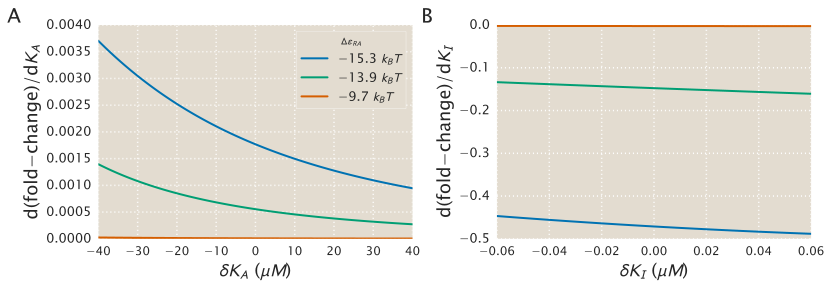

In [9]:
# Define the ranges to vary the dissociation constants
Ka_array = np.linspace(Ka_num - 40, Ka_num + 40, 100)
Ki_array = np.linspace(Ki_num - 0.06, Ki_num + 0.06, 100)

# Initialize plot
fig, ax = plt.subplots(1, 2, figsize=(11.5, 4))

# Loopt through binding energies
for eRA in  era_num:
    # Ka variabiliy
    dfc_dKa_array = dfc_dKa_num(5000, Ka_array, Ki_num, eai_num, 
                                130, Nns_num, eRA)
    ax[0].plot(Ka_array - Ka_num, dfc_dKa_array, label=r'{:.1f} $k_BT$'.format(eRA))
    
    # Ki variability
    dfc_dKi_array = dfc_dKi_num(5000, Ka_num, Ki_array, eai_num, 
                                130, Nns_num, eRA)
    
    ax[1].plot(Ki_array - Ki_num, dfc_dKi_array, label=r'{:.1f} $k_BT$'.format(eRA))
    
# Format Ka plot
ax[0].set_xlabel(r'$\delta K_A$ ($\mu M$)')
ax[0].set_ylabel(r'd(fold-change)/d$K_A$')
ax[0].legend(loc=0, title=r'$\Delta \varepsilon_{RA}$')

# Format Ki plot
ax[1].set_xlabel(r'$\delta K_I$ ($\mu M$)')
ax[1].set_ylabel(r'd(fold-change)/d$K_I$')
ax[1].set_xlim([np.min(Ki_array - Ki_num), np.max(Ki_array - Ki_num)])

# Label plot
plt.figtext(0.0, .95, 'A', fontsize=20)
plt.figtext(0.5, .95, 'B', fontsize=20)

plt.tight_layout()
plt.savefig(output + 'supplementary_figures/sensitivity_analysis.pdf',
           bbox_inches='tight')

We can see from these plots that the variability in fold-change as the value of the dissociation constants changes is strongly dependent on the repressor binding energy. The stronger the repressor binds to the promoter, the bigger the change in fold-change as the values of $K_A$ and $K_I$ change.

This explains the variability in the credible region width that we observe in the main text.